# Example 3: Optimized hyperparameters

In this example, we optimize the period and variance of the GP prior using the evidence lower bound.

Neuron `r2405_051216b_cell1816` was recorded by Dr. Marius Bauza and the Krupic lab; they have kindly shared this data to evaluate these GP methods. Please cite their work as

> Krupic J, Bauza M, Burton S, O’Keefe J. Local transformations of the hippocampal cognitive map. Science. 2018 Mar 9;359(6380):1143-6.

## Grid search to find kernel hyperparameters with best evidence lower-bound

In [2]:
import sys
sys.path.append('../')
from lgcpspatial.loaddata import Dataset

datadir  = '../example data/'
datasets = [
    'r2405_051216b_cell1816.mat',
]

from lgcpspatial.hyperparameters import gridsearch_optimize

# Load a dataset
L      = 128 # Grid size for position bins
dataset = datasets[0]
data   = Dataset.from_file(datadir+dataset).prepare(L,doplot=False)

result = gridsearch_optimize(data)
bestindex,bestpars,bestresult,allresults = result

[99,105](2.39e+01,7.78e-01) loss=-9.535699e+033(done)

Heuristic parameters
P  = 24.252948
v0 = 0.319910

Optimized parameters:
P    = 23.589750
β    = 0.778387
v0/β = 0.410991


## The heuristic parameters were close to optimal in this case

***Note:*** Since each time-sample adds independent information, it is helpful to normalize the evidence lower bound (ELBO). By default, `coordinate_descent` returns the negative ELBO (sometimes called the variational free energy) in units of nats-per-dataset. We can convert this to a more useful bits-per-second by:

1. Dividing by the total number of time samples, giving nats per sample
2. Multiply by `log2(e)` to convert to bits per sample
3. Multiplying by samples/second to get bits per second

This (negative) ELBO is also missing a $\ln(y!) = \ln\Gamma(y+1)$ term from the Poisson negative log-likelihood. This doesn't affect state or hyperparameter optimization, but it's good to add it back for completeness.

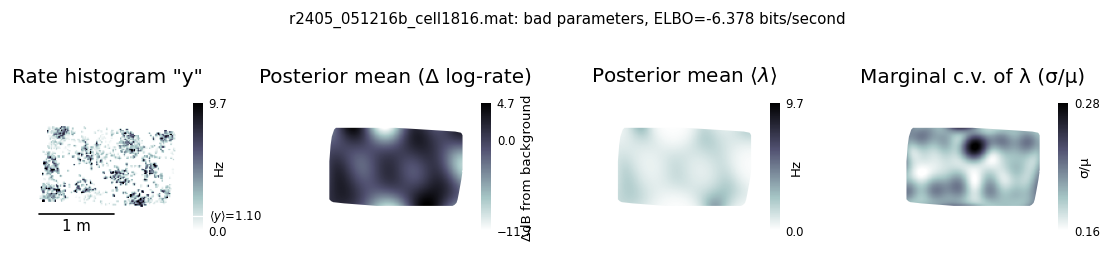

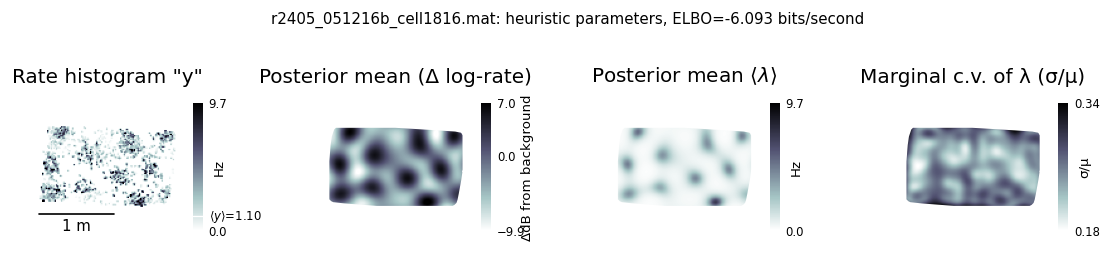

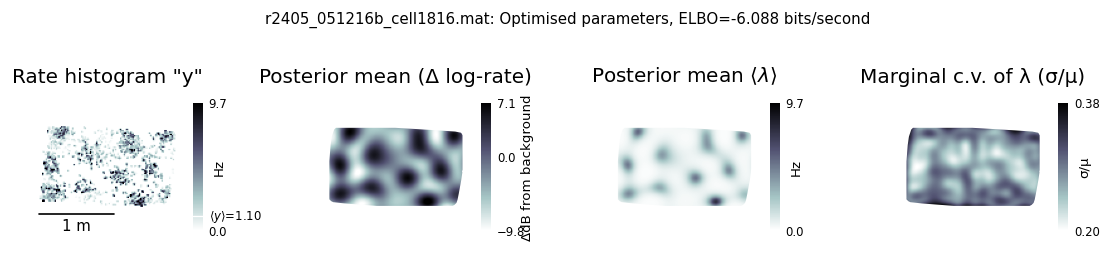

23.58975
0.4109905


In [4]:
from lgcpspatial.lgcp2d import DiagonalFourierLowrank
from lgcpspatial.lgcp2d import coordinate_descent
from scipy.special      import loggamma as lnΓ
from lgcpspatial.plot   import *

mask,mz = data.arena.mask,data.prior_mean
y,N     = data.y,data.n
Fs      = 50 # Hz

inbitspers = log2(e)*Fs
correction = average(lnΓ(data.y+1),weights=data.n)
totaltime  = sum(N)

def to_bps(vfe):
    '''
    The DiagonalFourierLowrank class returns the
    variational free energy in units of nats per dataset,
    with the constant contribution from the spikes
    removed. 
    This converts our result back to bits per spike,
    adding back this constant contribution.
    '''
    return -inbitspers*(vfe/totaltime+correction)
    
# Heuristic kernel parameters
P  = data.P
kv = data.prior_variance

P_use  = P*2
v0_use = kv
model  = DiagonalFourierLowrank(v0_use,P_use,data)
fit    = coordinate_descent(model)
inference_summary_plot(model,fit,data)
suptitle('%s: bad parameters, ELBO=%0.3f bits/second'%\
         (dataset,to_bps(fit[-1])))
show()

P_use  = P
v0_use = kv
model  = DiagonalFourierLowrank(v0_use,P_use,data)
fit    = coordinate_descent(model)
inference_summary_plot(model,fit,data)
suptitle('%s: heuristic parameters, ELBO=%0.3f bits/second'%\
         (dataset,to_bps(fit[-1])))
show()

P_use  = bestpars[0]
v0_use = kv/bestpars[1]
model  = DiagonalFourierLowrank(v0_use,P_use,data)
fit    = coordinate_descent(model)
inference_summary_plot(model,fit,data)
suptitle('%s: Optimised parameters, ELBO=%0.3f bits/second'%\
         (dataset,to_bps(fit[-1])))
show()

print(P_use)
print(v0_use)